# Title
by Zaki Aslam, Hector Palafox Prieto, Jennifer Tsang, and Samrawit Mezgebo Tsegay

In [1]:
import numpy as np
import pandas as pd
import altair as alt
import matplotlib.pyplot as plt
from sklearn.model_selection import (
    train_test_split, cross_validate,
    cross_val_predict, RandomizedSearchCV
)
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from scipy.stats import loguniform, randint
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from mglearn.tools import visualize_coefficients

# Summary

Here is the summary of our project...

- similar to the "About" section in the README

# Introduction

Food trucks and mobile food vendors are a common sight in Downtown Vancouver, offering a wide range of cuisine types from hot dogs and burgers to shawarma and tacos. With so many different vendors and food options, it can be useful to automatically identify what kind of food a vendor specializes in based only on select information. In this project, we study whether we can predict if a food vendor is a hot dog vendor or not using the vendor’s business name. We used a publicly available dataset of mobile food vendors in Vancouver from the City of Vancouver’s open data portal, where each row represents relevant information for a single food vendor and includes columns such as BUSINESS_NAME, LOCATION, DESCRIPTION, GEO_LOCALAREA, and geographic coordinates. For our analysis, we constructed a binary target variable named is_hotdog, which is True when the DESCRIPTION is “Hot Dogs” and False otherwise. This allows us to investigate how much information about the type of food a vendor sells can be extracted from the business name.

# Methods & Results

## Data

## Analysis

- describe in written english the methods you used to perform your analysis from beginning to end that narrates the code the does the analysis.
- your report should include code which:
    - loads data from the original source on the web
    - wrangles and cleans the data from it’s original (downloaded) format to the format necessary for the planned
    - classification or clustering analysis
    - performs a summary of the data set that is relevant for exploratory data analysis related to the planned classification analysis
    - creates a visualization of the dataset that is relevant for exploratory data analysis related to the planned classification analysis
    - performs classification or regression analysis
    - creates a visualization of the result of the analysis
- note: all tables and figure should have a figure/table number and a legend

In [2]:
# loads data from the original source on the web
url = (
    "https://opendata.vancouver.ca/api/explore/v2.1/"
    "catalog/datasets/food-vendors/exports/"
    "csv?lang=en&timezone=America%2FLos_Angeles"
    "&use_labels=true&delimiter=%3B"
)
food_vendors = pd.read_csv(url, sep = ";")

food_vendors.head(5)

,KEY,VENDOR_TYPE,STATUS,BUSINESS_NAME,LOCATION,DESCRIPTION,GEO_LOCALAREA,Geom,geo_point_2d
0,EB04,vendor_food,open,NaN,South Side of 1700 Beach Ave - East Side of Bi...,Hot Dogs,West End,"{""coordinates"": [-123.142926123068, 49.2844925...","49.2844925173, -123.142926123"
1,OD05,vendor_food,open,NaN,South Side of 1700 East Broadway - 37 Metres E...,Hot Dogs,Kensington-Cedar Cottage,"{""coordinates"": [-123.069072741187, 49.2622160...","49.2622160477, -123.069072741"
2,DT10,vendor_food,open,NaN,Expo Boulevard - 20 Metres West of Abbott St,Hot Dogs,Downtown,"{""coordinates"": [-123.108008079327, 49.2787930...","49.2787930538, -123.108008079"
3,C18,vendor_food,open,Aussie Pie Guy,Authorised Parking Meter - 1000 W Pender St,Australian Pies,Downtown,"{""coordinates"": [-123.118192426382, 49.2869519...","49.2869519782, -123.118192426"
4,C17,vendor_food,open,Le Tigre,Authorised Parking Meter North Side of Alberni...,Chinese Cuisine,West End,"{""coordinates"": [-123.12561890857, 49.28659154...","49.2865915482, -123.125618909"


In [5]:
# data wrangling and cleaning

# dropping irrelevant columns
clean_food = food_vendors.drop(columns=[
    'KEY', 'VENDOR_TYPE', 'STATUS', 'LOCATION',
    'GEO_LOCALAREA', 'Geom', 'geo_point_2d'
])

clean_food["is_hotdog"] = clean_food["DESCRIPTION"] == "Hot Dogs"
clean_food["BUSINESS_NAME"] = clean_food["BUSINESS_NAME"].fillna("")

clean_food.head()

,BUSINESS_NAME,DESCRIPTION,is_hotdog
0,,Hot Dogs,True
1,,Hot Dogs,True
2,,Hot Dogs,True
3,Aussie Pie Guy,Australian Pies,False
4,Le Tigre,Chinese Cuisine,False


In [6]:
# create train and test split

train_data, test_data = train_test_split(
    clean_food, train_size=0.7, random_state=522
)


In [10]:
# summary EDA, identify missing and NAN values

train_data["text_is_na"] = train_data["BUSINESS_NAME"] == ""

In [11]:
# Data visualization for EDA
# Code in this cell adapted from DSCI 351 Lecture 2 and 5 
# color names supported for the bar charts located at: https://www.w3schools.com/cssref/css_colors.php


plot1 = (alt.Chart(clean_food,title="What are the most common cuisine types among food vendors in Downtown Vancouver?").mark_bar
    (color="chocolate").encode(
        x=alt.X("count()", title="Total"),
        y=alt.Y("DESCRIPTION:N", sort='-x', title="Food type")
    ).properties(
        width=250,
        height=500
    )
)

plot2 = (alt.Chart(train_data,title="Are we dealing with a class imbalance in our train data?").mark_bar(color="seagreen").encode(
    x=alt.X("is_hotdog", title="Is it a hot dog vendor?"),
    y=alt.Y("count()", title="Number of vendors")
).properties(
        width=85,
        height=495
    )
        )



combined = (plot1 | plot2).configure_axis(
    labelFontSize=12,
    titleFontSize=13
).configure_title(
    fontSize=15
)

combined

alt.HConcatChart(...)

When visualizing our EDA we can notice several key points. In the first plot (on the left) we can see that of all the cusine types from Downtown Vancouver food vendors, hot dog stands seem to be the most common of them all. It is also very important to analyze our classes before starting our work. When you have a large class imbalance, a lot of the times your model will give you a score that is not representaive of whether or not your model works well. For example, if you ran the above plot for a data set where one class is represenated in a much higher proportion than the other, a model like DummyClassifier will give you an extremely high score. This isn't because the model works perfectly it's because it'll always predict the higher represented class! When looking at our second plot (on the left) we can see that we do not have that issue here as the class imbalance isn't too skewed!

### Helper Functions

These are some auxiliary methods to improve the readability of the analysis.

In [12]:
def build_pipeline(model):
    return make_pipeline(
        CountVectorizer(),
        model
    )

model_comparison = dict()

def add_to_model_comparison(model_name, model):
    model_comparison[model_name] = pd.DataFrame(
        cross_validate(
            model,
            X_train,
            y_train,
            cv=5,
            return_train_score=True,
        )
    ).agg(['mean', 'std']).round(3).T

def show_cv_scores(model):
    return pd.DataFrame(
        cross_validate(
            model,
            X_train,
            y_train,
            cv=5,
            return_train_score=True,
        )
    )

def record_and_display_cv_scores(model_name, model):
    add_to_model_comparison(model_name, model)
    return show_cv_scores(model)

def compare_models(param='mean'):
    return pd.concat(
        model_comparison,
        axis='columns'
    ).xs(
        param,
        axis='columns',
        level=1
    ).style.format(
        precision=2
    ).background_gradient(
        axis=None
    )

def display_model_mistmatches(model):
    data_dict = {
        "y": y_train,
        "y_hat": cross_val_predict(
            model,
            X_train,
            y_train
        ).tolist(),
        "x": X_train.tolist(),
        "probabilities": cross_val_predict(
            model,
            X_train,
            y_train,
            method="predict_proba"
        ).tolist(),
    }
    
    df = pd.DataFrame(data_dict)
    return df[df["y"] != df["y_hat"]].sort_values('probabilities')

def display_confusion_matrix(model):
    ConfusionMatrixDisplay.from_predictions(
        y_train,
        cross_val_predict(
            model,
            X_train,
            y_train
        )
    )

### Data Preparation

We will perform the preparation of our data for the analysis, as well as getting some relevant features out of it.

In [13]:
## Here we are splitting our data into inputs and responses

X_train = train_data["BUSINESS_NAME"]
y_train = train_data["is_hotdog"]

X_test = test_data["BUSINESS_NAME"]
y_test = test_data["is_hotdog"]

In [14]:
## Here we are obtaining the vocabulary of our BOW.

bag_of_words = build_pipeline(DummyClassifier())
bag_of_words.fit(X_train, y_train)
vocab = (
    bag_of_words.named_steps["countvectorizer"].get_feature_names_out()
)

## Display the first 5 tokens

pd.DataFrame({"words": vocab}).head()

,words
0,actual
1,ali
2,arancino
3,arepa
4,arturo


<p style="text-align: center"><small>Table X: First 5 elements of the vocabulary.</small></p>

We will also take a look at the proportions of our target variable in the training and test sets.

In [15]:
# look at the proportion of each class for train and test data

data_proportion = pd.DataFrame({
    "train": y_train.value_counts(normalize=True),
    "test": y_test.value_counts(normalize=True)
})

data_proportion

,train,test
is_hotdog,,
False,0.634921,0.714286
True,0.365079,0.285714


<p style="text-align: center"><small>Table X: Train and test proportions of the target class.</small></p>

For all our models, a `True` prediction will mean that the vendor is a Hot Dog seller, and `False` the other way around.

We can observe that the data is relatively balanced in both sets: being around **34%** of our total data. Yet the target class is less prominent in our test split. We will not balance the data set, yet this is something we can consider for future analysis.

### Baseline (`DummyClassifier`)

Here we are defining a dummy classifier to have a reference to compare our different models. For this and all our models we will use 5 folds.

In [16]:
# DummyClassifier as baseline

dummy = DummyClassifier()

record_and_display_cv_scores("Baseline", dummy)

,fit_time,score_time,test_score,train_score
0,0.000431,0.000539,0.615385,0.640000
1,0.000313,0.000439,0.615385,0.640000
2,0.000667,0.000761,0.615385,0.640000
3,0.000447,0.000634,0.666667,0.627451
4,0.000348,0.000500,0.666667,0.627451


<p style="text-align: center"><small>Table X: DummyClassifier cross validation scores and times.</small></p>

As expected, the dummy consistently predicts the majority class, with acccuracy of around **0.63**, being consistent with the representation of our split.

### Decision Tree

Here we are training a simple decision tree to identify whether the vendor sells hot dogs or not. This is a simple model with easy to interpret coeffiecients, and it would be interesting checking whether or not it correctly identified the pattern for the empty names.

#### Cross Validation

In [17]:
tree = build_pipeline(DecisionTreeClassifier(random_state=522))

record_and_display_cv_scores("Decision Tree",  tree)

,fit_time,score_time,test_score,train_score
0,0.001540,0.000652,0.538462,0.980000
1,0.001447,0.000623,0.384615,1.000000
2,0.001322,0.000545,0.461538,0.980000
3,0.001244,0.000543,0.333333,0.980392
4,0.001321,0.000555,0.333333,0.980392


<p style="text-align: center"><small>Table X: Decision tree cross validation scores and times.</small></p>

The tree performs worse than the dummy classifier, as it is overfitting the prediction, which is evident in the substantial gap between the validation and training scores (around **-0.65** difference for all folds).

#### Model Parameters

We can take a look at the depths and tree structure to better understand these discrepancies:

In [18]:
tree.fit(X_train, y_train)

print(
    "The max depth of the tree is:",
    tree["decisiontreeclassifier"].tree_.max_depth
)

The max depth of the tree is: 36


As we can see, the model contains 36 levels of decisions, yet, the level of specificity (given that we are using a bag of words) makes it perform poorly. Here we can see the most discriminating factors:

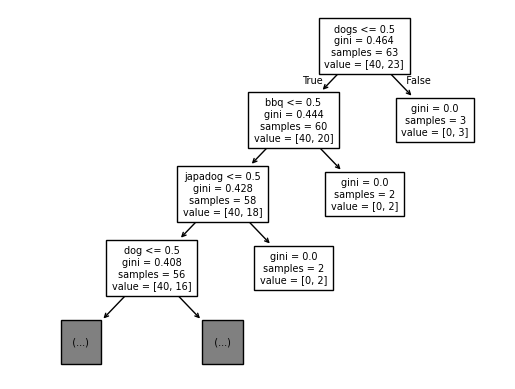

In [19]:
plot_tree(
    tree["decisiontreeclassifier"],
    feature_names=vocab,
    max_depth=3,
    fontsize=7
)
plt.show()

<p style="text-align: center"><small>Fig. X: Decision tree structure (limited to the first 5 levels of the depth)</small></p>

We can observe some sensible initial discriminations, such as "dogs", "japadog" and "dogs", which would quickly identify the vendor as a Hot Dog place.

#### Performance Metrics

Here we can observe the confussion metrics and misses in the cross validation of the model trained.

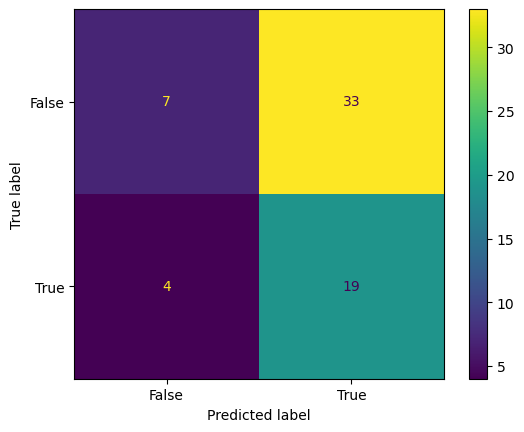

In [20]:
display_confusion_matrix(tree)

<p style="text-align: center"><small>Fig. X: Confusion matrix for the Decision Tree.</small></p>

We can observe that the model is very good at identifying when something seems "Hot-Doggy", yet, it produces a high degree of false positives.

We can observe some of the mistakes below:

In [21]:
display_model_mistmatches(tree)

,y,y_hat,x,probabilities
39,False,True,Marimba,"[0.0, 1.0]"
14,False,True,Mogu,"[0.0, 1.0]"
35,False,True,Commissary Connect,"[0.0, 1.0]"
3,False,True,Aussie Pie Guy,"[0.0, 1.0]"
69,False,True,Lemon Sea,"[0.0, 1.0]"
78,False,True,San Juan Family Farm,"[0.0, 1.0]"
61,False,True,Suassy Thai,"[0.0, 1.0]"
4,False,True,Le Tigre,"[0.0, 1.0]"
18,False,True,Vie Niapolotan,"[0.0, 1.0]"
48,False,True,Come Arepa,"[0.0, 1.0]"


<p style="text-align: center"><small>Table X: Mismatches for Decision Tree.</small></p>

### Logistic Regression

Here we will train a logistic regression in order to see whether or not we can improve our accuracy and reduce the possible overfitting. This model also has the advantage of having interpretable parameters, which in our case relate how often each of our features is associated with the target variable (`is_hotdog = True`).

#### Cross Validation

In [22]:
lr = build_pipeline(LogisticRegression(random_state=522))

record_and_display_cv_scores("Logistic Regression", lr)

,fit_time,score_time,test_score,train_score
0,0.002196,0.000713,0.615385,0.780000
1,0.002112,0.000723,0.615385,0.820000
2,0.002186,0.000517,0.615385,0.840000
3,0.002138,0.000487,0.833333,0.784314
4,0.001757,0.000477,0.750000,0.823529


<p style="text-align: center"><small>Table X: Logistic regression cross validation scores and times.</small></p>

#### Model Parameters

We can take a look at the coefficients associated with each word and see which ones are the most relevant:

In [23]:
lr.fit(X_train, y_train)

print(
    "Number of coefficients: ",
    len(lr["logisticregression"].coef_[0]),
)

Number of coefficients:  95


In [24]:
lr_coefficients = pd.DataFrame({
    "token": vocab,
    "coefficient": lr["logisticregression"].coef_[0]
})

lr_coefficients

,token,coefficient
0,actual,-0.288868
1,ali,0.252019
2,arancino,-0.274974
3,arepa,-0.288868
4,arturo,-0.206981
...,...,...
90,tube,0.450637
91,van,0.190846
92,vie,-0.288868
93,wraps,-0.347684


<p style="text-align: center"><small>Table X: Coefficients of the logistic regression.</small></p>

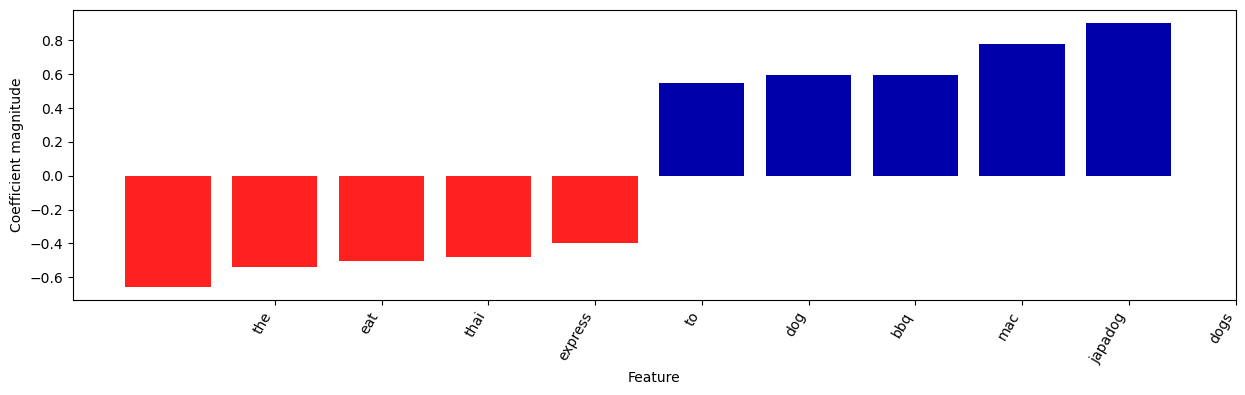

In [25]:
visualize_coefficients(
    lr_coefficients['coefficient'].to_numpy(),
    vocab,
    n_top_features=5
)

<p style="text-align: center"><small>Fig. X: Top 5 most discriminant features (upper and lower).</small></p>

#### Performance Metrics

Here we can observe the confusion metrics and misses in the cross validation of the model trained.

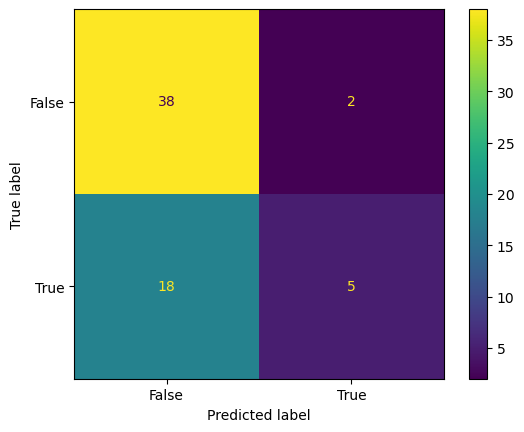

In [26]:
ConfusionMatrixDisplay.from_predictions(
    y_train,
    cross_val_predict(
        lr,
        X_train,
        y_train
    )
)

<p style="text-align: center"><small>Fig. X: Confusion matrix for the Logistic Regression.</small></p>

In [27]:
display_model_mistmatches(lr)

,y,y_hat,x,probabilities
64,False,True,Van Dog,"[0.2667999752011667, 0.7332000247988333]"
69,False,True,Lemon Sea,"[0.46275075909225794, 0.5372492409077421]"
16,True,False,Sea Dogs,"[0.5044715315798389, 0.495528468420161]"
63,True,False,Van Dog,"[0.5408657706168261, 0.4591342293831739]"
44,True,False,,"[0.5559202270628496, 0.44407977293715034]"
83,True,False,Dog Meister,"[0.5610386009395438, 0.4389613990604562]"
8,True,False,,"[0.5767844402459679, 0.4232155597540322]"
1,True,False,,"[0.5767844402459679, 0.4232155597540322]"
32,True,False,,"[0.5767844402459679, 0.4232155597540322]"
65,True,False,,"[0.5810117083158131, 0.418988291684187]"


<p style="text-align: center"><small>Table X: Mismatches for Logistic Regression.</small></p>

### Naïve Bayes

Finally we will be testing the Naïve-Bayes model, which is also a relatively simple model that also does not tend to over-fit as much, just to see which model is best.

#### Cross Validation

In [28]:
naive_bayes = build_pipeline(BernoulliNB())

record_and_display_cv_scores("Naïve-Bayes", naive_bayes)

,fit_time,score_time,test_score,train_score
0,0.001449,0.000685,0.692308,0.780000
1,0.001668,0.000857,0.615385,0.820000
2,0.001457,0.000681,0.692308,0.840000
3,0.001196,0.000586,0.833333,0.784314
4,0.001166,0.000600,0.750000,0.823529


<p style="text-align: center"><small>Table X: Naïve-Bayes cross validation scores and times.</small></p>

#### Performance Metrics

Here we can observe the confusion metrics and misses in the cross validation of the model trained.

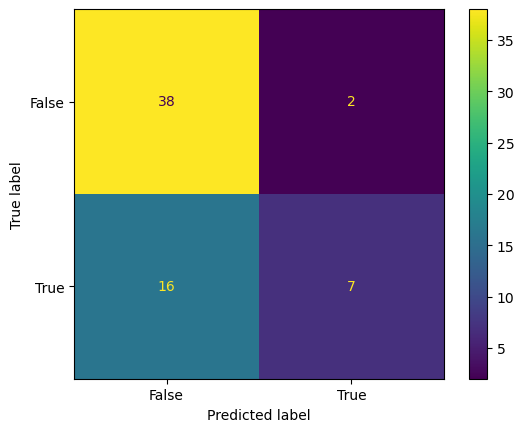

In [29]:
# confusion matrix for test predictions

ConfusionMatrixDisplay.from_predictions(
    y_train,
    cross_val_predict(
        naive_bayes,
        X_train,
        y_train
    )
)

<p style="text-align: center"><small>Fig. X: Confusion matrix for the Naïve-Bayes classifier</small></p>

In [30]:
display_model_mistmatches(naive_bayes)

,y,y_hat,x,probabilities
64,False,True,Van Dog,"[0.044828809023268835, 0.9551711909767308]"
69,False,True,Lemon Sea,"[0.29784367729882794, 0.702156322701172]"
83,True,False,Dog Meister,"[0.56089848046478, 0.43910151953521964]"
44,True,False,,"[0.5957116734789062, 0.40428832652109337]"
8,True,False,,"[0.6711991921260541, 0.32880080787394605]"
1,True,False,,"[0.6711991921260541, 0.32880080787394605]"
32,True,False,,"[0.6711991921260541, 0.32880080787394605]"
37,True,False,Holy Smokes,"[0.692765469630229, 0.3072345303697712]"
68,True,False,,"[0.692765469630229, 0.3072345303697712]"
80,True,False,,"[0.692765469630229, 0.3072345303697712]"


<p style="text-align: center"><small>Table X: Mismatches for Naïve-Bayes.</small></p>

### Model Comparisons

Knowing this, we can compare their scores to determine the model to train.



In [31]:
compare_models()

,Baseline,Decision Tree,Logistic Regression,Naïve-Bayes
fit_time,0.00,0.00,0.01,0.00
score_time,0.00,0.00,0.00,0.00
test_score,0.64,0.41,0.69,0.72
train_score,0.64,0.98,0.81,0.81


<p style="text-align: center"><small>Table X: Comparisons of mean values of scores and times for all models.</small></p>

### Best Model Hyperparameter Optimisation

In [32]:
param_grid = {
    "countvectorizer__max_features": randint(5, len(vocab)),
    "bernoullinb__alpha": loguniform(1e-5, 1),
}

random_search = RandomizedSearchCV(
    naive_bayes,
    param_distributions=param_grid,
    n_iter=50,
    n_jobs=-1,
    return_train_score=True,
)

random_search.fit(X_train, y_train)

print(
    "Random Search best model score: \t %0.3f"
    % random_search.best_score_
)
print(
    "Random Search best max_features: \t %0.3f"
    % random_search.best_params_["countvectorizer__max_features"]
)
print(
    "Random Search best alpha: \t\t %0.3f"
    % random_search.best_params_["bernoullinb__alpha"]
)

pd.DataFrame(random_search.cv_results_)[
    [
        "mean_test_score",
        "param_countvectorizer__max_features",
        "param_bernoullinb__alpha",
        "mean_fit_time",
        "rank_test_score",
    ]
].set_index("rank_test_score").sort_index().head()




Random Search best model score: 	 0.732
Random Search best max_features: 	 63.000
Random Search best alpha: 		 0.656


,mean_test_score,param_countvectorizer__max_features,param_bernoullinb__alpha,mean_fit_time
rank_test_score,,,,
1,0.732051,63,0.656454,0.004173
1,0.732051,64,0.675022,0.001447
3,0.698718,45,0.545081,0.002269
3,0.698718,19,0.121614,0.001138
3,0.698718,29,0.317094,0.000772


<p style="text-align: center"><small>Table X: Best hyperparameters for the best model (Naïve-Bayes).</small></p>

In [33]:
print(
    "Best model test score:",
    random_search.score(X_test, y_test)
)

Best model test score: 0.7857142857142857


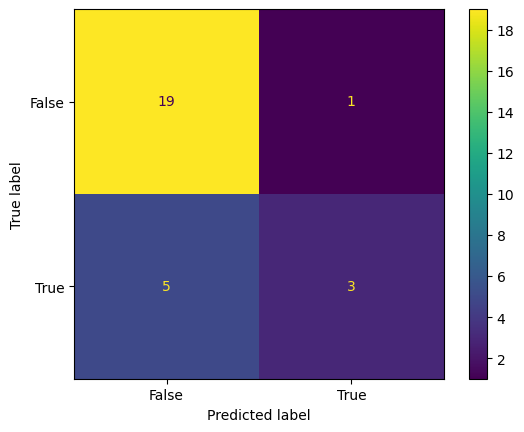

In [34]:
# confusion matrix for test predictions

ConfusionMatrixDisplay.from_predictions(
    y_test,
    random_search.predict(X_test)
)

<p style="text-align: center"><small>Fig. X: Confusion matrix for the best Naïve-Bayes classifier</small></p>

In [35]:
display_model_mistmatches(random_search.best_estimator_)

,y,y_hat,x,probabilities
64,False,True,Van Dog,"[0.016545189615389005, 0.9834548103846112]"
69,False,True,Lemon Sea,"[0.19238266868668152, 0.8076173313133181]"
44,True,False,,"[0.5127048479874297, 0.48729515201257007]"
32,True,False,,"[0.5626071841060438, 0.43739281589395634]"
8,True,False,,"[0.5626071841060438, 0.43739281589395634]"
1,True,False,,"[0.5626071841060438, 0.43739281589395634]"
12,True,False,Japadog,"[0.5772247008152174, 0.4227752991847824]"
65,True,False,,"[0.5772247008152174, 0.4227752991847824]"
86,True,False,Japadog,"[0.5772247008152174, 0.4227752991847824]"
68,True,False,,"[0.607953777276216, 0.39204622272378414]"


<p style="text-align: center"><small>Table X: Mismatches for best
Naïve-Bayes.</small></p>

# Discussion

For the context of this research question, <insert research question>, we want to minimize false positives (FPs), where our indicator labels the restaurant selling hotdogs while it actually doesn’t → hangry (hungry and angry) customers. 

We compared the performance of 4 different models (Dummy, Decision Tree, Logistic Regression, and Naive-Bayes), and Naive-Bayes had the highest accuracy, therefore, we chose Naive-Bayes to move forward with hyperparameter tuning. We used RandomizedSearchCV to identify the best hyperparameter values for Max Features and alpha, and evaluated the best model with the test set.

A test accuracy of 0.79 shows that our model is still a work in progress, but it shows promising results from the confusion matrix, where it only has 1 FP. There are also 5 FN, but that is less costly from our context perspective of trying to satisfy the customers. By analyzing the prediction probabilities, we can see that for the 1 FP mistake, the model is very confident about the prediction (99.99%). That is because the restaurant’s name has the word “dog” in it, resulting in this overconfident case... (need to adjust this paragraph after fixing the analysis!)

Some challenges in the data set are the size. It is a small dataset with only _ entries. Another challenge is the imbalance of classes. It would be ideal if each class would represent roughly 50–50% of the samples. We believe that the imbalance was not severe, so we didn’t make any adjustments. In the future, we can take the argument “class_weight” into account during hyperparameter tuning. 

*** Please proofread, and more details need to be added once the Introduction has been added regarding the purpose and relevance of this project.
- summarize what you found
- discuss whether this is what you expected to find?
- discuss what impact could such findings have?
- discuss what future questions could this lead to?

# References

- UBC Master of Data Science Program. DSCI 531: Effective use of Visual Channels– Lecture 2: Bar Chart syntax. 2025.
- UBC Master of Data Science Program. DSCI 531: Visualization for communication– Lecture 5: axis label formatting. 2025.
- W3Schools. CSS Color Names. W3Schools.com. https://www.w3schools.com/cssref/css_colors.php (accessed 21 November 2025).

# Note:
- Make sure to render to PDF form and push to GitHub.
- Everyone should contribute equally to the code and writing!
- Git commit messages should be meaningful; they will be marked!
- Use GitHub issues to assign tasks and communicate!
- Proper grammar and full sentences in README